In [115]:
import math
import os

import numpy as np
import pandas as pd

from lifelines import WeibullFitter
from tqdm.autonotebook import tqdm

### Constants 

## Load files
Load the failure data that has been exported from the Poles 1 Model

In [116]:

intervention_filename = os.getcwd() + "\\Outputs\\TInterventions.csv"
intervention_history_filename = os.getcwd() + "\\Outputs\\TInterventionsPoleHistory.csv"

mapping_filename = os.getcwd() + "\\ACS - Poles - Failure Cause Mapping.xlsx"

In [117]:
df_interventions = pd.read_csv(intervention_filename)
df_ih = pd.read_csv(intervention_history_filename)
df_map = pd.read_excel(mapping_filename, sheet_name = "Map Cause-Reason")

In [118]:
df_interventions.head()

,Unnamed: 0,Asset ID,Feeder Area,Latitude,Longitude,Task Description,Cause Description,WASP Failure Type,Saftey Factor,SF Calculation Type,...,Reinforcement,Min Wall Thick Vicinity of GL,Calculated Bending Moment GL,Completed Inspection Level,Intervention Date,Installation Date,Age (hrs),Age (yrs),Intervention Type,Failure Type
0,1,1000027-2018-02-24,BAR22 Wakool,-35.355453,144.039734,Pole - Pole Failure,Vehicle Damage,Functional,NaN,NaN,...,None,NaN,NaN,Level 1,24/02/2018,1/01/1989,255504.0,29.167123,Replacement,Functional
1,2,1000100-2016-04-13,BAR22 Wakool,-35.423996,144.141281,Pole - Condemned - Replace,Internal Pipe,NaN,4.89,Detailed,...,None,NaN,NaN,Level 4,13/04/2016,25/12/1985,265608.0,30.320548,Replacement,Conditional
2,3,418-2019-08-07,CBR42 Margretvale,-31.526566,145.961029,Pole - Condemned - Replace,Termite (Insect) Damage,Conditional,4.00,Standard,...,None,NaN,NaN,Level 3,7/08/2019,1/01/1964,487368.0,55.635616,Replacement,Conditional
3,4,1000166-2016-04-13,BAR22 Wakool,-35.413605,144.115463,Pole - Condemned - Replace,Internal Pipe,NaN,4.64,Detailed,...,None,NaN,NaN,Level 4,13/04/2016,25/12/1991,213024.0,24.317808,Replacement,Conditional
4,5,419-2019-08-07,CBR42 Margretvale,-31.527904,145.963806,Pole - replace,Pole (timber) deteriorated below grd ( 0 - 0.4...,Conditional,4.59,Standard,...,None,NaN,NaN,Level 4,7/08/2019,NaN,NaN,NaN,Replacement,Conditional


## Cleansing
Do some minor renaming to make it esaier to read

In [119]:
#Rename the columns

df_ih = df_ih.rename(columns = {
    "Interventions.Cause Description": "Cause Description",
    "Interventions.Intervention Date": "Intervention Date",
    "Interventions.Intervention Type" : "Intervention Trigger",
    "Interventions.TWASP.Failure Type" : "Failure Type",
    "TMapCauseReason.Reason":"Cause Code"
})


In [120]:
df_interventions = df_interventions.merge(df_map, on = 'Cause Description')
df_interventions['Cause Code'] = df_interventions['Reason']

In [121]:
def filter_data(df, pole_material=None, pole_type=None, intervention_trigger=None, failure_classification=None):

    if pole_material:
        df = df.loc[df['Pole Material']==pole_material]

    if pole_type:
        df = df.loc[df["Pole Type"]==pole_type]

    if intervention_trigger:
        df = df.loc[(df["Intervention Trigger"] == intervention_trigger) | (df['Intervention Trigger'].isnull())]

    if failure_classification:
        df = df.loc[df["Failure Classification"] == failure_classification]

        
    df.loc[:,'Intervention Date'] = pd.to_datetime(df["Intervention Date"])
    df.loc[:,'Age (yrs)'] = df['Age (hrs)']/8760
    df.loc[df['NoInterventionData']!=False, 'Cause Code'] = 'Unknown'
    
    return df

In [122]:
df = filter_data (
    df = df_ih,
    pole_material = "Timber",
    pole_type = None,#"Copper Chrome Arsenic(CCA)"
    intervention_trigger = None,#"Replacement",
    failure_classification = None,
)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


## Method 1 - Fit a weibull to the sub population

## Method 3 - Adjust for the missing assets

In [123]:
#df['Intervention Date'] = pd.to_datetime(df['Intervention Date'])
#df = df.loc[df['Intervention Date'] > pd.to_datetime("01/01/2015")]

## Preparation
Adjust the data so it is in the required format with the correct headings

In [124]:
df['Age'] = df['Age (yrs)'].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Sorting



####  Dates - Intervention dates
Select a date range with asset ages that we can verify

In [125]:
min_date = pd.datetime(1965,1,1)
max_date= pd.datetime(2020,1,1)

In [126]:
date_col = 'Intervention Date'
mask_valid_date = (df[date_col] > min_date) & (df[date_col] < max_date)

print(f"In Date Range: {sum(~mask_valid_date)}. Out of Date Range: {sum(mask_valid_date)}")

In Date Range: 1202791. Out of Date Range: 35443


#### Age
The low volume of poles aged greater than 70 is expected to skew the results so will be filtered

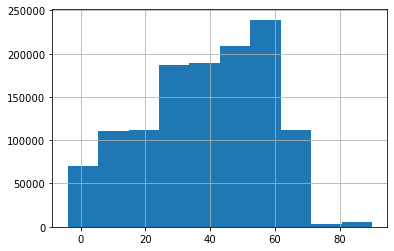

In [127]:
df['Age'].hist();

In [128]:
min_age = 0
max_age = 75

In [129]:
mask_valid_age = (df['Age'] > min_age) & (df['Age'] < max_age)
df = df.loc[mask_valid_age]

print(f"In Age Range: {sum(~mask_valid_age)}. Out of Age Range: {sum(mask_valid_age)}")

In Age Range: 15326. Out of Age Range: 1222908


## Failure Causes
We need to divide the data set up into three sets:
- Unknown - Assets where the age and cause of failure cannot be verified
- Failed - Assets we know have failed due to the cause/s of interest
- In Service - Assets which are in service

### Failed assets - Unassisted
To evalute this method, lets consider unassisted failure modes with should be impacted by age

In [130]:
unassisted = [
    '(fungal decay - other)',
    '(fungal decay - internal)',
    '(fungal decay - internal - brown rot)',
    '(fungal decay - internal - white rot)',
    '(fungal decay - external)', 
    '(fungal decay - external - soft rot)',
    '(termites)',
    '(weathering)',
]

unknown = ['Unknown', '(Unknown)']

assisted = set(df_interventions['Cause Code'].unique()) - set(unassisted) - set(unknown)

print(assisted)

{'(any reason)', '(augmentation)', '(impact)', '(fire damage - external cause)', '(concrete failure - extreme environment)', '(concrete failure - impact)', '(corrosion)', '(installation error)', '(extreme environment)', '(fire damage - asset related)', '(related asset failure)', '(fire damage)', '(lightning strike)'}


In [131]:
mask_unassisted = df_interventions['Cause Code'].isin(unassisted)
print(f"Unassisted Failures: {sum(mask_unassisted)}")

Unassisted Failures: 17469


## Simplify the dataframe

In [173]:
cause = unassisted #['(concrete failure - extreme environment)'] #unassisted

In [174]:
def cause_age_count(df, cause=cause):
    """
    Returns the df
    """
    df = df.groupby(by=['Cause Code', 'Age']).count()['Asset ID'].reset_index()
    df = df.rename(columns={'Asset ID':'assets'})
    
    mask = df['Cause Code'].isin(cause)
    df_cause = df.loc[mask].groupby(by=['Age']).sum()
    df_not_cause = df.loc[~mask].groupby(by=['Age']).sum()
    
    return df_cause, df_not_cause

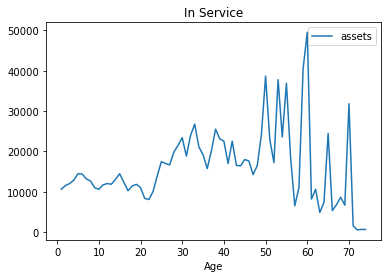

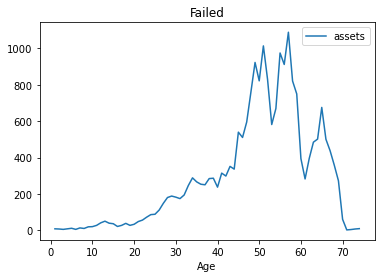

In [175]:
df_failed, df_is = cause_age_count(df, cause=cause)

df_is.plot(title = 'In Service')
df_failed.plot(title = "Failed")

In [176]:
def smooth_profile(df, window=3):
    return df.rolling(window=window, min_periods=0).mean().astype(int)

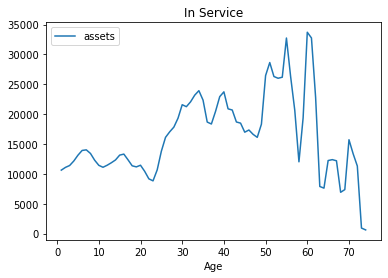

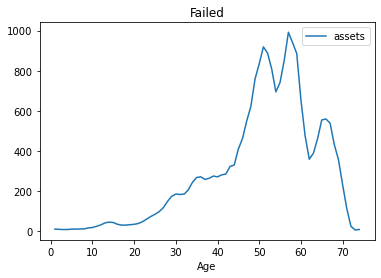

In [177]:
df_is_smooth = smooth_profile(df_is)
df_failed_smooth = smooth_profile(df_failed)

df_is_smooth.plot(title = 'In Service')
df_failed_smooth.plot(title = "Failed")

### Get the annual failure rate

In [178]:
def get_reliability(df_is, df_failed):
    
    # Cumulative failure 
    df = df_failed / (df_is + df_failed)
    df = df.rename(columns={'assets' : 'cff'})
    
    # Cumulative Survival
    df['csf'] = 1 - df['cff']
    
    # Reliability
    df['R'] = df['csf'].cumprod()
    
    t_0 = {'cff':0, 'csf':1, 'R':1}
    df.loc[0] = pd.Series(t_0)
    
    return df.sort_index()
    

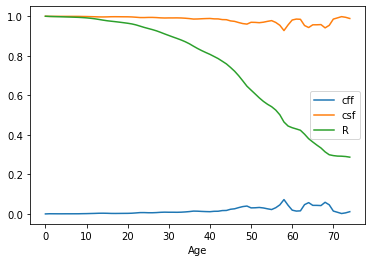

In [179]:
df_r = get_reliability(df_is_smooth, df_failed_smooth)
df_r.plot();

### Create a sample from these failure rates

In [180]:
def resample(df, n_sample=100000):
    
    df = pd.DataFrame(((df['R']*n_sample).diff()*-1).dropna())
    df = df.rename(columns={'R':'assets'})
    df['event_observed'] = True
    
    # Add the failure events that haven't been observed yet
    age_survivor = df.index.max() + 1
    n_survivors = n_sample - df.sum()[0]
    
    df.loc[age_survivor] = pd.Series({'assets':n_survivors, 'event_observed':False})
    
    return df                                      

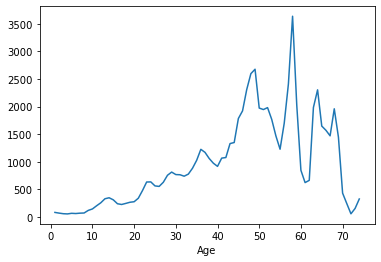

In [181]:
df_rs = resample(df_r)
df_rs.loc[df_rs['event_observed'], 'assets'].plot()

### Fit a weibull back to this data

In [182]:
def fit_weibull(df, n_sample=100000):
    wbf = WeibullFitter()

    durations = list(df.index)
    weights = list(df['assets'].values.astype(int))
    event_observed = list(df['event_observed'])                

    wbf.fit(durations, weights=weights, event_observed=event_observed)
    
    return wbf

In [183]:
wbf = fit_weibull(df_rs)
wbf.print_summary()

In [150]:
def cause_to_wbf(df, cause, window=3, n_sample=1e6, simple=True):
    
    df_f, df_is = cause_age_count(df, cause)
    
    df_f = smooth_profile(df_f, window)
    df_is = smooth_profile(df_is, window)
    
    df_r = get_reliability(df_is, df_f)
    
    df_rs = resample(df_r, n_sample)
    
    wbf = fit_weibull(df_rs, n_sample)
    
    if simple:
        return wbf
    else:
        return (df_f, df_is, df_r, df_s, wbf)

In [151]:
results = cause_to_wbf(df, cause= ['(impact)'], window=3, simple=False)
wbf = results[-1]
wbf.print_summary()

## Evaluate for a wider data set

In [107]:
causes = list(df['Cause Code'].unique())
causes

['In Service',
 '(fungal decay - internal)',
 '(fungal decay - external)',
 '(augmentation)',
 '(termites)',
 '(fire damage)',
 '(concrete failure - impact)',
 '(fungal decay - external - soft rot)',
 '(lightning strike)',
 '(concrete failure - concrete spalling)',
 '(weathering)',
 '(impact)',
 '(related asset failure)',
 '(unknown)',
 'Unknown',
 '(fungal decay - internal - brown rot)',
 '(fungal decay - other)',
 '(concrete failure - corrosion of reinforcement)',
 '(fire damage - external cause)',
 '(fire damage - asset related)',
 '(extreme environment)',
 '(any reason)',
 '(fungal decay - internal - white rot)',
 '(concrete failure - extreme environment)',
 '(concrete failure - cracking / splitting)',
 '(corrosion)',
 '(installation error)']

In [185]:
wbf_results = dict()

for cause in tqdm(causes):
    try:
        # Get the weibull for each method
        wbf = cause_to_wbf(df=df, cause=[cause])

        wbf_results[cause] = {'lambda':wbf.lambda_, 'rho': wbf.rho_}
    
    except:
        wbf_results[cause] = {'lambda':None, 'rho': None}
    
wbf_results = pd.DataFrame(wbf_results).T.sort_index()
wbf_results

C:\Users\gtresede\AppData\Roaming\Python\Python37\site-packages\lifelines\fitters\__init__.py:941: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

To fix this, try specifying an `initial_point` kwarg in `fit`.

  warnings.warn(warning_text, utils.StatisticalWarning)
C:\Users\gtresede\AppData\Roaming\Python\Python37\site-packages\lifelines\fitters\__init__.py:941: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

To fix this, try specifying an `initia

,lambda,rho
(any reason),361.571,3.21968
(augmentation),100.715,2.41501
(concrete failure - concrete spalling),106016,1.17484
(concrete failure - corrosion of reinforcement),0.805253,1.18527e-05
(concrete failure - cracking / splitting),99787.9,1.11708
(concrete failure - extreme environment),None,None
(concrete failure - impact),0.805253,1.18527e-05
(corrosion),487.498,3.21988
(extreme environment),247.4,4.56355
(fire damage - asset related),5411.88,1.34935


In [186]:
wbf

{'alpha': 0.05,
 '_class_name': 'WeibullFitter',
 '_label': 'Weibull_estimate',
 '_estimate_name': 'cumulative_hazard_',
 '_bounds': [(1e-09, None), (1e-09, None)],
 '_censoring_type': 3,
 'durations': array([40, 58, 59, 67, 68]),
 'event_observed': array([1, 1, 1, 1, 0]),
 'entry': array([0., 0., 0., 0., 0.]),
 'weights': array([    41,    154,     98,     78, 999626]),
 'timeline': array([40., 47., 54., 61., 68.]),
 '_ci_labels': None,
 '_initial_values': array([10.0518655,  1.       ]),
 '_fitted_parameters_': array([3.02803459e+05, 9.53491241e-01]),
 'log_likelihood_': -4884.0941874108275,
 '_hessian_': array([[2.88450638e-09, 8.90971724e-03],
        [8.90971724e-03, 2.38352509e+04]]),
 'lambda_': 302803.45864302927,
 'rho_': 0.9534912411065856,
 'variance_matrix_':               lambda_        rho_
 lambda_ -2.242236e+09  838.157112
 rho_     8.381571e+02   -0.000271,
 'survival_function_':       Weibull_estimate
 40.0          0.999800
 47.0          0.999767
 54.0          0.99

In [70]:

df3 = df3 / 1e6 * df_unassisted.sum()[0]
pd.concat([df3, df_unassisted], axis=1).plot()

TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

## Assets that failed with no date
Consider the assets that have received an intervention,  

In [79]:
df_unassisted = df.loc[mask_date].groupby(by=['Cause Code', 'Age']).count()['Asset ID'].reset_index()

# Remove failures that happened at age 0
mask_failed_too_early = (df_unassisted['Age']==0)
n_failures = df_unassisted['Age'].sum()
n_failed_too_early =  sum(mask_failed_too_early)

print(f"Intervention Date prior to Failure Date: {n_failed_too_early}")

NameError: name 'mask_date' is not defined

In [80]:
df_unassisted = df_unassisted.loc[~mask_failed_too_early & mask_unassisted].groupby(by=['Age']).sum()
df_unassisted.plot(title='Unassisted Failures');

# Lower the number of failures
df_unassisted = df_unassisted.rolling(window=3, min_periods=0).mean().div(4).astype(int) # Change to 4
df_unassisted.plot(title = 'Unassisted Failures smoothed');

# Spread the missing failures out evenly
n_fte = sum(mask_failed_too_early)
n_failures = sum(mask_unassisted)

df_unassisted = df_unassisted * (1 + n_failed_too_early / n_failures)

NameError: name 'df_unassisted' is not defined

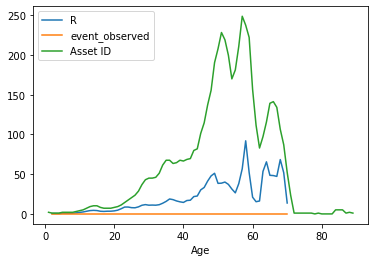

In [16]:
df3 = df3 / 1000000 * df_unassisted.sum()[0]
pd.concat([df3, df_unassisted], axis=1).plot()

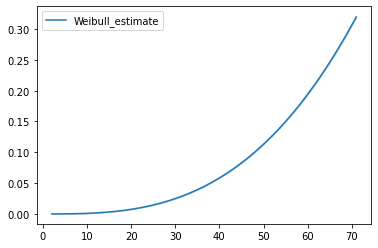

In [17]:
wbf.plot()

In [18]:
alpha = wbf.lambda_
beta = wbf.rho_


t = np.array(df_is.reset_index()['Age'])

df_is['pof'] = 1- np.exp((t ** beta - (t + 1)**beta) / (alpha**beta))

df_is.prod(axis=1).sum()


6122.442258976818

In [175]:
df_sim['failed'] = df_sim['rand'] < df_sim['sf']

In [176]:
df_sim['failed'].value_counts()

False    978089
True      10674
Name: failed, dtype: int64

In [332]:
pd.concat([pd.DataFrame(df_sim.groupby(by=['Age']).sum()['failed']),df_unassisted], axis=1).plot()

MemoryError: Unable to allocate 37.7 MiB for an array with shape (5, 988763) and data type float64

## Method 1 - Simple
Use the reliability package to fit the data for the whole population

In [23]:
from reliability.Fitters import Fit_Weibull_3P, Fit_Weibull_2P
from reliability.Probability_plotting import plot_points
from matplotlib import pyplot as plt

In [42]:
# Prepare the failure and censored data
failures = df.loc[df['Cause Code'].isin(unassisted), "Age (yrs)"].values
right_censored = df.loc[~df['Cause Code'].isin(unassisted), "Age (yrs)"].values


Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error  Lower CI  Upper CI
Parameter                                                    
Alpha           65.530126             NaN       NaN       NaN
Beta             1.219410             NaN       NaN       NaN
Log-Likelihood: nan


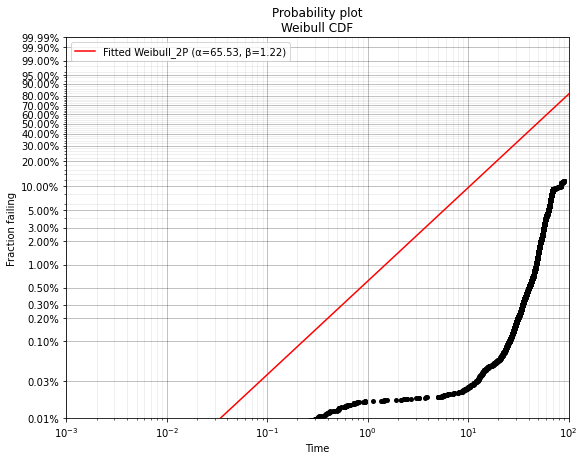

In [68]:
# Fit a weibull to the data

percent_sample = 1
f_count = int(len(failures) * percent_sample)
rc_count = int(len(right_censored) * percent_sample)

wbf = Fit_Weibull_2P(failures=np.random.choice(failures,f_count), right_censored = np.random.choice(right_censored, rc_count), show_probability_plot=True,print_results=True)
plt.show()


(array([ 289.,  295.,  554., 1776., 2429., 6174., 5958., 3401.,   45.,
         112.]),
 array([2.73972603e-03, 8.92986301e+00, 1.78569863e+01, 2.67841096e+01,
        3.57112329e+01, 4.46383562e+01, 5.35654795e+01, 6.24926027e+01,
        7.14197260e+01, 8.03468493e+01, 8.92739726e+01]),
 <a list of 10 Patch objects>)

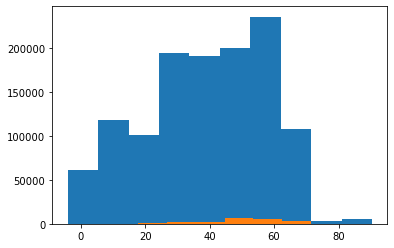

In [50]:
plt.hist(right_censored)
plt.hist(failures)

## Method - Lifelines

In [119]:
#Trying a lifeline mehtod

from lifelines import WeibullFitter

df = df.loc[df['Age (yrs)'] >= 0]
# Prepare the failure and censored data
durations = df['Age (yrs)']
event_observed =df['Cause Code'].isin(unassisted)

wbf = WeibullFitter()
wbf.fit(durations, event_observed)

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 1.23814e+06 total observations, 1.2171e+06 right-censored observations>

In [124]:
wbf.print_summary()

In [118]:
event_observed[event_observed].count()

66366

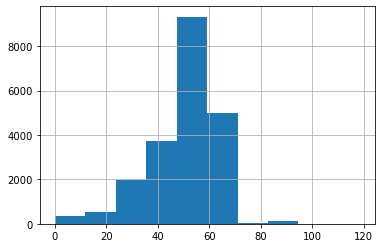

In [19]:
df.loc[df["Cause Code"].isin(unassisted), "Age (yrs)"].hist()

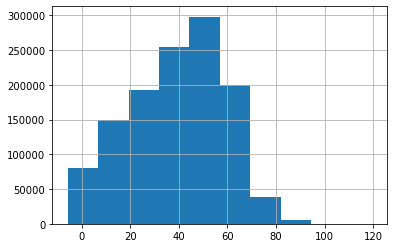

In [20]:
df.loc[~df["Cause Code"].isin(unassisted), "Age (yrs)"].hist()

In [18]:
df_interventions

,Unnamed: 0,Asset ID,Feeder Area,Latitude,Longitude,Task Description,Cause Description,WASP Failure Type,Saftey Factor,SF Calculation Type,...,Reinforcement,Min Wall Thick Vicinity of GL,Calculated Bending Moment GL,Completed Inspection Level,Intervention Date,Installation Date,Age (hrs),Age (yrs),Intervention Type,Failure Type
0,1,1000100-2016-04-13,BAR22 Wakool,-35.423996,144.141281,Pole - Condemned - Replace,Internal Pipe,NaN,4.890,Detailed,...,None,NaN,NaN,Level 4,13/04/2016,25/12/1985,265608.0,30.320548,Replacement,Conditional
1,2,1000166-2016-04-13,BAR22 Wakool,-35.413605,144.115463,Pole - Condemned - Replace,Internal Pipe,NaN,4.640,Detailed,...,None,NaN,NaN,Level 4,13/04/2016,25/12/1991,213024.0,24.317808,Replacement,Conditional
2,3,418-2019-08-07,CBR42 Margretvale,-31.526566,145.961029,Pole - Condemned - Replace,Termite (Insect) Damage,Conditional,4.000,Standard,...,None,NaN,NaN,Level 3,7/08/2019,1/01/1964,487368.0,55.635616,Replacement,Conditional
3,4,1000178-2017-06-23,BAR22 Wakool,-35.354111,143.981979,Pole - Condemned - Replace,External Decay Above,NaN,2.050,Standard,...,None,NaN,NaN,Level 1,23/06/2017,1/01/1985,284664.0,32.495890,Replacement,Conditional
4,5,419-2019-08-07,CBR42 Margretvale,-31.527904,145.963806,Pole - replace,Pole (timber) deteriorated above grd ( 0 - 1.8...,Conditional,4.590,Standard,...,None,NaN,NaN,Level 4,7/08/2019,NaN,NaN,NaN,Replacement,Conditional
5,6,1000330-2016-06-10,BAR22 Wakool,-35.309982,144.296341,Pole - Condemned - Replace,Internal Decay Above,NaN,5.540,Detailed,...,None,NaN,NaN,Level 4,10/06/2016,25/12/1993,196872.0,22.473973,Replacement,Conditional
6,7,1000562-2016-06-10,BAR22 Wakool,-35.302254,144.249130,Pole - Condemned - Replace,Internal Decay Above,NaN,3.510,Detailed,...,None,NaN,NaN,Level 4,10/06/2016,25/12/1974,363432.0,41.487671,Replacement,Conditional
7,8,1000590-2015-04-15,BAR22 Wakool,-35.583843,144.286591,Pole - Condemned - Replace,Termite (Insect) Damage,NaN,2.300,Standard,...,None,NaN,NaN,Level 3,15/04/2015,1/03/1979,316656.0,36.147945,Replacement,Conditional
8,9,450-2019-08-29,CBR42 Margretvale,-31.543837,146.034622,Pole - replace,Pole (timber) deteriorated above grd ( 0 - 1.8...,Old Task,4.590,Detailed,...,None,NaN,NaN,Level 4,29/08/2019,NaN,NaN,NaN,Replacement,Conditional
9,10,1000749-2015-04-16,BAR22 Wakool,-35.678768,144.353043,Pole - Condemned - Replace,Termite (Insect) Damage,Old Task,2.020,Standard,...,None,NaN,NaN,Level 3,16/04/2015,1/05/1987,245088.0,27.978082,Replacement,Conditional


In [25]:
df = filter_data (
    df = df_ih,
    pole_material = "Timber",
    pole_type = False,#"Copper Chrome Arsenic(CCA)"
    intervention_trigger = "Replacement",
    failure_classification = False,
)

(array([7.98570e+04, 1.50094e+05, 1.93136e+05, 2.58027e+05, 3.06671e+05,
        2.05793e+05, 3.87130e+04, 5.88000e+03, 1.00000e+00, 6.20000e+01]),
 array([ -5.81369863,   6.72465753,  19.2630137 ,  31.80136986,
         44.33972603,  56.87808219,  69.41643836,  81.95479452,
         94.49315068, 107.03150685, 119.56986301]),
 <a list of 10 Patch objects>)

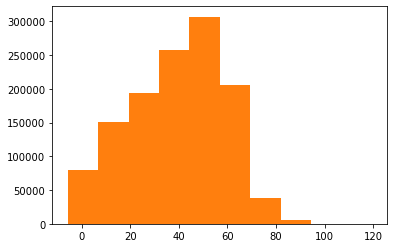

In [31]:
plt.hist(right_censored)
plt.hist(failures)

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error   Lower CI   Upper CI
Parameter                                                      
Alpha           44.420607        0.021356  44.378769  44.462484
Beta             1.974798        0.001562   1.971739   1.977861
Log-Likelihood: -5237957.023471345


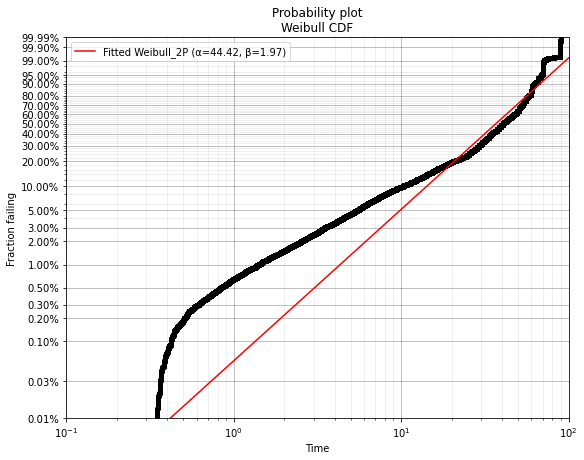

In [21]:
# Prepare the failure and censored data
failures = df.loc[df["Cause Code"].isin(['In Service', 'Augmentation']), "Age (yrs)"].values
right_censored = df.loc[~df["Cause Code"].isin(['In Service', 'Augmentation']), "Age (yrs)"].values

# Fit a weibull to the data
wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=True)
plt.show()


In [16]:
df.groupby('Cause Code').count()['Age (yrs)']

Cause Code
(any reason)                                           123
(augmentation)                                        3756
(concrete failure - concrete spalling)                   5
(concrete failure - corrosion of reinforcement)          6
(concrete failure - cracking / splitting)                7
(concrete failure - extreme environment)                 3
(concrete failure - impact)                              8
(corrosion)                                             39
(extreme environment)                                  107
(fire damage - asset related)                           74
(fire damage - external cause)                        2485
(fire damage)                                          165
(fungal decay - external - soft rot)                   585
(fungal decay - external)                             2492
(fungal decay - internal - brown rot)                 1877
(fungal decay - internal - white rot)                  397
(fungal decay - internal)                    

## Discussion with C55

How far down do you go?

Pole material = All 
Pole Type = All 
Failure Mode = All


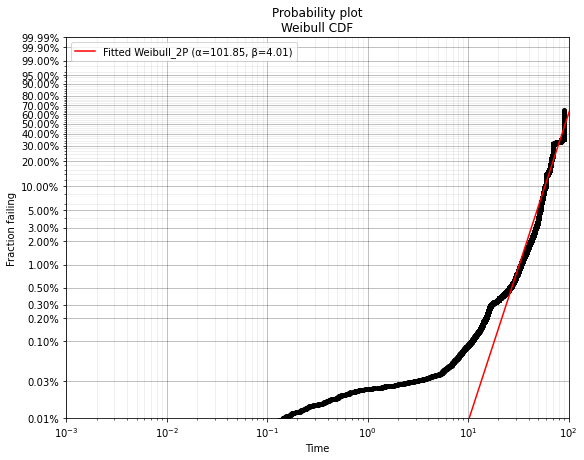

Pole material = Timber 
Pole Type = All 
Failure Mode = All


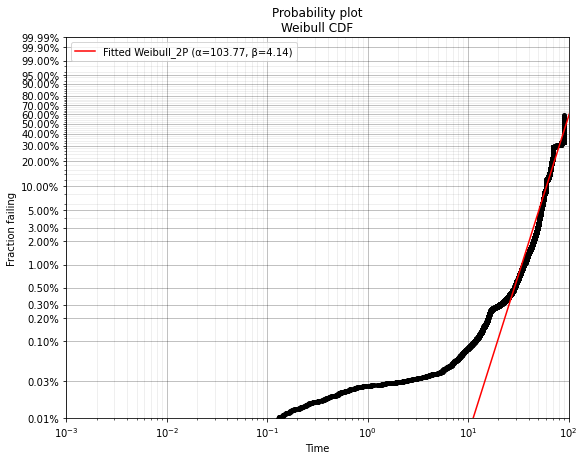

Pole material = Timber 
Pole Type = Copper Chrome Asenic(CCA) 
Failure Mode = All


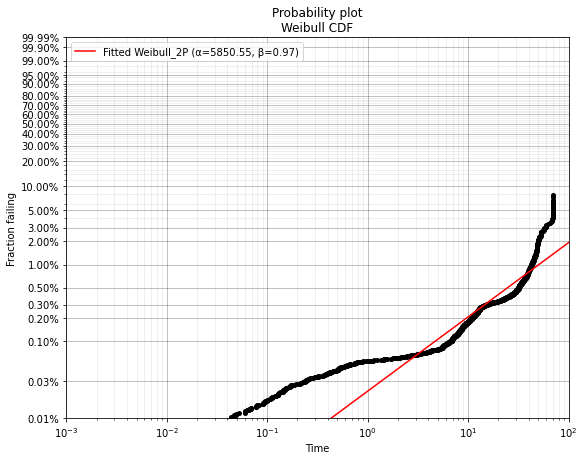

Pole material = Timber 
Pole Type = Copper Chrome Asenic(CCA) 
Failure Mode = Fungal Decay Internal


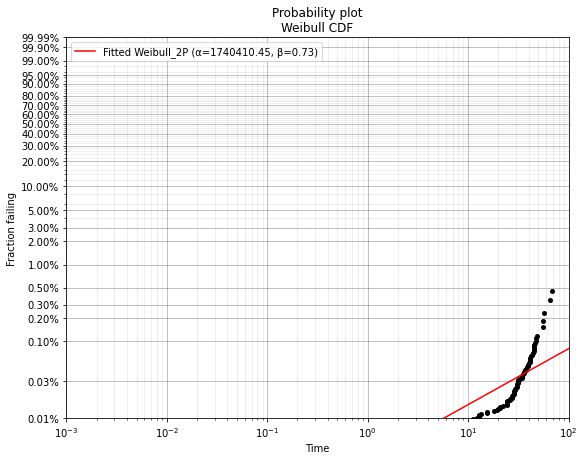

In [31]:
print("Pole material = All \nPole Type = All \nFailure Mode = All")
df = filter_data (
    df = df_ih,
    pole_material = None,
    pole_type = None,
    intervention_trigger = "Replacement",
    failure_classification = False,
)

# Prepare the failure and censored data
failures = df.loc[df["Cause Code"] != 'In Service', "Age (yrs)"].values
right_censored = df.loc[df["Cause Code"] == 'In Service', "Age (yrs)"].values

# Fit a weibull to the data
wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=False)
plt.show()


print("Pole material = Timber \nPole Type = All \nFailure Mode = All")
df = filter_data (
    df = df_ih,
    pole_material = "Timber",
    pole_type = None,
    intervention_trigger = "Replacement",
    failure_classification = False,
)

# Prepare the failure and censored data
failures = df.loc[df["Cause Code"] != 'In Service', "Age (yrs)"].values
right_censored = df.loc[df["Cause Code"] == 'In Service', "Age (yrs)"].values

# Fit a weibull to the data
wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=False)
plt.show()


print("Pole material = Timber \nPole Type = Copper Chrome Asenic(CCA) \nFailure Mode = All")
df = filter_data (
    df = df_ih,
    pole_material = "Timber",
    pole_type = "Copper Chrome Arsenic(CCA)",
    intervention_trigger = "Replacement",
    failure_classification = False,
)

# Prepare the failure and censored data
failures = df.loc[df["Cause Code"] != 'In Service', "Age (yrs)"].values
right_censored = df.loc[df["Cause Code"] == 'In Service', "Age (yrs)"].values

# Fit a weibull to the data
wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=False)
plt.show()

print("Pole material = Timber \nPole Type = Copper Chrome Asenic(CCA) \nFailure Mode = Fungal Decay Internal")
df = filter_data (
    df = df_ih,
    pole_material = "Timber",
    pole_type = "Copper Chrome Arsenic(CCA)",
    intervention_trigger = "Replacement",
    failure_classification = False,
)

# Prepare the failure and censored data
failures = df.loc[df["Cause Code"] == '(fungal decay - internal)', "Age (yrs)"].values
right_censored = df.loc[df["Cause Code"] != '(fungal decay - internal)', "Age (yrs)"].values

# Fit a weibull to the data
wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=False)
plt.show()

In [ ]:
print("Pole material and Pole Type")
df = filter_data (
    df = df_ih,
    pole_material = "Timber",
    pole_type = "Copper Chrome Arsenic(CCA)",
    intervention_trigger = "Replacement",
    failure_classification = False,
)

# Prepare the failure and censored data
failures = df.loc[df["Cause Code"] != 'In Service', "Age (yrs)"].values
right_censored = df.loc[df["Cause Code"] == 'In Service', "Age (yrs)"].values

# Fit a weibull to the data
wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=False)
plt.show()

## Method 2 - Simple
Use the reliability package to fit the data

In [9]:
from reliability.Fitters import Fit_Weibull_3P, Fit_Weibull_2P
from reliability.Probability_plotting import plot_points
from matplotlib import pyplot as plt

(lightning strike)
Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error    Lower CI     Upper CI
Parameter                                                         
Alpha         1429.773210      597.071143  630.676532  3241.362774
Beta             1.955242        0.220770    1.567074     2.439559
Log-Likelihood: -415.506032738285


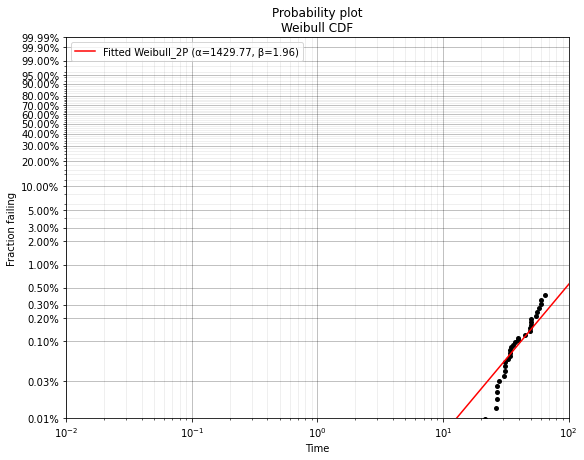

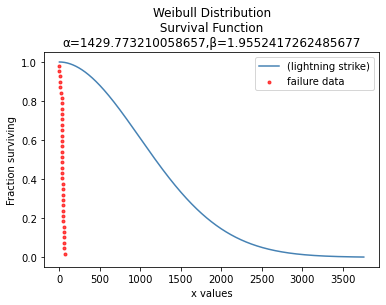

In [10]:
# Get the cause codes that have been used and drop the default "In Service"
cause_codes = list(df["Cause Code"].unique())
cause_codes.remove('In Service')

cause_codes = ["(lightning strike)"]

df['Age (yrs)'] = df['Age (hrs)']/8760

survival = dict()

for cause_code in tqdm(cause_codes):
    
    print (cause_code)
    
    # Prepare the failure and censored data
    failures = df.loc[df["Cause Code"] == cause_code, "Age (yrs)"].values
    right_censored = df.loc[df["Cause Code"] != cause_code, "Age (yrs)"].values

    # Fit a weibull to the data
    wbf = Fit_Weibull_2P(failures=failures, right_censored = right_censored, show_probability_plot=True,print_results=True)
    plt.show()
    
    # Plot hthe results
    wbf.distribution.SF(label=cause_code,color='steelblue')
    plot_points(failures=failures, func='SF',label='failure data',color='red',alpha=0.7)
    plt.legend()
    plt.show()
    
    
    # Save the results
    survival[cause_code] = wbf.results


In [20]:
df.loc[df["Cause Code"] != cause_code]

,Unnamed: 0,Asset ID,Installation Date,Pole Material,...,Faiure Type,Cause Code,Age (hrs),Age (yrs)
13,14,1000012,25/12/1996,Timber,...,NaN,In Service,204240,23.315068
18,19,1000017,25/12/1994,Timber,...,NaN,In Service,221784,25.317808
19,20,1000018,25/12/2014,Timber,...,NaN,In Service,46464,5.304110
23,24,1000022,25/12/1994,Timber,...,NaN,In Service,221784,25.317808
28,29,1000027,24/02/2018,Timber,...,NaN,In Service,18696,2.134247
33,34,1000032,25/12/1988,Timber,...,NaN,In Service,274368,31.320548
40,41,1000039,25/12/1979,Timber,...,NaN,In Service,353280,40.328767
57,58,1000056,25/12/1989,Timber,...,NaN,In Service,265608,30.320548
58,59,1000057,25/12/1988,Timber,...,NaN,In Service,274368,31.320548
78,79,1000330-2016-06-10,25/12/1993,Timber,...,Functional,(fungal decay - internal),196872,22.473973


In [8]:
df.groupby("Cause Code").count()

,Unnamed: 0,Asset ID,Installation Date,Pole Material,...,Intervention Date,Intervention Trigger,Faiure Type,Age (hrs)
Cause Code,,,,,,,,,
(any reason),9,9,9,9,...,9,9,9,9
(augmentation),180,180,180,180,...,180,180,180,180
(corrosion),3,3,3,3,...,3,3,3,3
(extreme environment),3,3,3,3,...,3,3,3,3
(fire damage - asset related),8,8,8,8,...,8,8,8,8
(fire damage - external cause),554,554,554,554,...,554,554,554,554
(fire damage),24,24,24,24,...,24,24,24,24
(fungal decay - external - soft rot),11,11,11,11,...,11,11,11,11
(fungal decay - external),68,68,68,68,...,68,68,68,68


In [9]:
censoring = pd.concat(survival)

In [10]:
censoring

Point Estimate  Standard Error      Lower CI      Upper CI
                                      Parameter                                                            
(any reason)                          Alpha        5.528022e+07    1.590136e+07  3.145730e+07  9.714444e+07
                                      Beta         1.898795e+00    1.119056e-01  1.691658e+00  2.131296e+00
(augmentation)                        Alpha        5.023314e+07    5.913958e+06  3.988212e+07  6.327068e+07
                                      Beta         1.402619e+00    3.275958e-02  1.339859e+00  1.468319e+00
(corrosion)                           Alpha        3.344652e+07    1.663610e+07  1.261736e+07  8.866116e+07
                                      Beta         2.350169e+00    2.618159e-01  1.889177e+00  2.923650e+00
(extreme environment)                 Alpha        1.691980e+06    1.614485e+05  1.403375e+06  2.039937e+06
                                      Beta         6.378714e+00    4.511757e-01  5.552984e+00  7.327231e+00
(fire damage - asset related)         Alpha        3.413884e+07    1.305648e+07  1.613261e+07  7.224250e+07
                                      Beta         2.152227e+00    1.805629e-01  1.825895e+00  2.536882e+00
(fire damage - external cause)        Alpha        1.662170e+07    2.061836e+06  1.303432e+07  2.119643e+07
                                      Beta         1.542818e+00    4.592475e-02  1.455382e+00  1.635506e+00
(fire damage)                         Alpha        2.679385e+07    6.520223e+06  1.663019e+07  4.316911e+07
                                      Beta         2.031608e+00    1.132859e-01  1.821275e+00  2.266232e+00
(fungal decay - external - soft rot)  Alpha        2.587261e+07    1.175522e+07  1.061933e+07  6.303528e+07
                                      Beta         2.242347e+00    2.322480e-01  1.830378e+00  2.747039e+00
(fungal decay - external)             Alpha        3.324492e+07    3.858749e+06  2.648049e+07  4.173732e+07
                                      Beta         1.685698e+00    4.402264e-02  1.601586e+00  1.774227e+00
(fungal decay - internal - brown rot) Alpha        3.847125e+07    6.447062e+06  2.770070e+07  5.342957e+07
                                      Beta         1.773456e+00    6.443083e-02  1.651565e+00  1.904343e+00
(fungal decay - internal - white rot) Alpha        3.651831e+07    1.491678e+07  1.639898e+07  8.132133e+07
                                      Beta         2.149407e+00    1.899916e-01  1.807502e+00  2.555987e+00
(fungal decay - internal)             Alpha        3.303164e+07    4.015272e+06  2.602912e+07  4.191803e+07
                                      Beta         1.605205e+00    4.254614e-02  1.523945e+00  1.690798e+00
(fungal decay - other)                Alpha        5.477365e+07    1.214536e+07  3.546733e+07  8.458918e+07
                                      Beta         1.699498e+00    7.497330e-02  1.558726e+00  1.852983e+00
(impact)                              Alpha        2.060468e+07    6.628721e+06  1.096797e+07  3.870842e+07
                                      Beta         2.265509e+00    1.763389e-01  1.944963e+00  2.638884e+00
(lightning strike)                    Alpha        1.300747e+06    3.350198e+04  1.236714e+06  1.368095e+06
                                      Beta         5.537527e+00    1.242653e-01  5.299250e+00  5.786518e+00
(related asset failure)               Alpha        3.246372e+07    2.002537e+07  9.690167e+06  1.087590e+08
                                      Beta         2.262738e+00    3.032075e-01  1.740095e+00  2.942358e+00
(termites)                            Alpha        2.469692e+07    1.963689e+06  2.113307e+07  2.886178e+07
                                      Beta         1.631275e+00    3.112699e-02  1.571394e+00  1.693438e+00
(unknown)                             Alpha        5.456192e+07    8.952424e+06  3.955724e+07  7.525811e+07
                                      Beta         1.

In [21]:
no_censoring = pd.concat(survival)

In [89]:
no_censoring

Point Estimate  Standard Error       Lower CI       Upper CI
                                      Parameter                                                              
(any reason)                          Alpha       477053.120912    15313.354368  447964.153249  508031.007664
                                      Beta             2.855293        0.236780       2.426964       3.359215
(augmentation)                        Alpha       478097.184902     1270.482857  475613.557682  480593.781483
                                      Beta             4.232400        0.037248       4.160021       4.306038
(concrete failure)                    Alpha       311217.735710    15759.729026  281812.605033  343691.081557
                                      Beta             3.712350        0.452482       2.923478       4.714092
(corrosion)                           Alpha       414895.915937    18339.142483  380464.839035  452442.915611
                                      Beta             3.257906        0.405518       2.552629       4.158047
(extreme environment)                 Alpha       489249.482345    13328.772132  463810.774073  516083.431769
                                      Beta             3.605114        0.316605       3.035048       4.282254
(fire damage - asset related)         Alpha       403150.339561    23636.869769  359385.651858  452244.532990
                                      Beta             2.057970        0.200827       1.699709       2.491746
(fire damage - external cause)        Alpha       364034.977707     3976.847097  356323.353345  371913.498652
                                      Beta             1.916821        0.032091       1.854944       1.980762
(fire damage)                         Alpha       376623.636031    15587.513956  347278.950776  408447.914567
                                      Beta             1.912327        0.123413       1.685114       2.170176
(fungal decay - external - soft rot)  Alpha       488134.446073     2947.172446  482392.137114  493945.110442
                                      Beta             5.213382        0.126689       4.970897       5.467696
(fungal decay - external)             Alpha       493550.025655     2125.700236  489401.265240  497733.956010
                                      Beta             4.399301        0.069183       4.265773       4.537009
(fungal decay - internal - brown rot) Alpha       480010.122999     2178.192201  475759.873469  484298.342568
                                      Beta             4.533935        0.073252       4.392612       4.679803
(fungal decay - internal - white rot) Alpha       514893.224853     4095.939098  506927.590694  522984.027435
                                      Beta             6.111431        0.234344       5.668961       6.588438
(fungal decay - internal)             Alpha       477578.970793     1651.142415  474353.730933  480826.139799
                                      Beta             4.144917        0.047569       4.052725       4.239206
(fungal decay - other)                Alpha       494119.107664     4204.636934  485946.511575  502429.149594
                                      Beta             3.859511        0.104596       3.659857       4.070057
(impact)                              Alpha       443871.498305     9738.950195  425188.110609  463375.861393
                                      Beta             3.168749        0.183283       2.829136       3.549130
(installation error)                  Alpha       485479.133425    29036.400393  431777.880975  545859.339666
                                      Beta             4.671656        1.065250       2.987971       7.304076
(lightning strike)                    Alpha       435513.654169     8127.458708  419871.930666  451738.087533
                                      Beta             2.284105        0.085363       2.122777       2.457694
(related asset failure)               Alpha       462274.856873    17039.284136  430056.2

In [33]:
df.loc[~df["Intervention Date"].isnull()].groupby("Cause Code").count()

,Unnamed: 0,Asset ID,Installation Date,Pole Material,Pole Type,Cause Description,Intervention Date,Age (hrs)
Cause Code,,,,,,,,
(any reason),123,123,123,123,30,123,123,123
(augmentation),8481,8481,8481,8481,5588,8481,8481,8481
(concrete failure),32,32,32,32,8,32,32,32
(corrosion),51,51,51,51,24,51,51,51
(extreme environment),107,107,107,107,19,107,107,107
(fire damage - asset related),74,74,74,74,19,74,74,74
(fire damage - external cause),2479,2479,2479,2479,770,2479,2479,2479
(fire damage),171,171,171,171,57,171,171,171
(fungal decay - external - soft rot),1092,1092,1092,1092,611,1092,1092,1092


In [12]:
df.loc[df["Cause Code"] == cause_code]

,Unnamed: 0,Asset ID,Installation Date,Pole Material,...,Faiure Type,Cause Code,Age (hrs),Age (yrs)
86,87,1000800-2016-11-18,1/01/1999,Timber,...,Functional,(termites),156744,17.893151
103,104,1001016-2018-03-15,25/12/1990,Timber,...,Functional,(termites),238608,27.238356
107,108,1001535-2019-08-05,11/04/2019,Timber,...,Functional,(termites),2784,0.317808
231,232,1006215-2016-06-29,1/01/1994,Timber,...,Functional,(termites),197160,22.506849
244,245,1006276-2016-06-28,1/01/2015,Timber,...,Functional,(termites),13056,1.490411
440,441,1010473-2016-08-30,25/12/1979,Timber,...,Functional,(termites),321552,36.706849
523,524,1011383-2016-05-04,1/01/1994,Timber,...,Functional,(termites),195816,22.353425
596,597,1012589-2016-11-16,1/01/1995,Timber,...,Functional,(termites),191760,21.890411
875,876,1020294-2016-06-09,1/01/1981,Timber,...,Functional,(termites),310632,35.460274
878,879,1020332-2016-03-31,1/01/1986,Timber,...,Functional,(termites),265128,30.265753


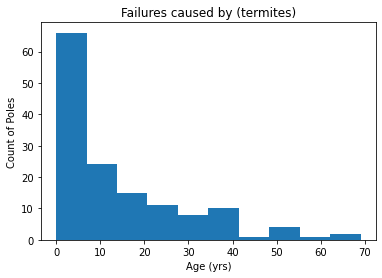

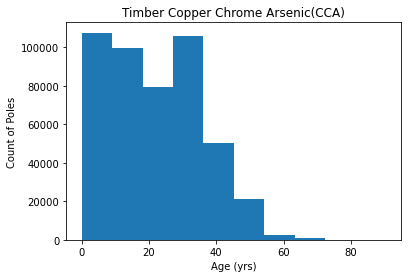

In [15]:
df = df_ih

pole_material = "Timber"
pole_type = "Copper Chrome Arsenic(CCA)"
intervention_trigger = "Replacement"
failure_classification = False
cause_code = "(termites)"

if pole_material:
    df = df.loc[df['Pole Material']==pole_material]

if pole_type:
    df = df.loc[df["Pole Type"]==pole_type]

if intervention_trigger:
    df = df.loc[(df["Intervention Trigger"] == intervention_trigger) | (df['Intervention Trigger'].isnull())]

if failure_classification:
    df = df.loc[df["Failure Classification"] == failure_classification]


ax = plt.hist(df.loc[df["Cause Code"] == cause_code,"Age (hrs)"]/365/24);
plt.title("Failures caused by " + cause_code)
plt.ylabel("Count of Poles")
plt.xlabel("Age (yrs)")
plt.show()

plt.hist(df["Age (hrs)"]/365/24);
plt.title(pole_material + " " + pole_type)
plt.ylabel("Count of Poles")
plt.xlabel("Age (yrs)")
plt.show()